# Project : INTRODUCTION TO MACHINE LEARNING

## Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import math 
import random 
import matplotlib.pyplot as plt 

## Chargement des données

In [30]:
dataset = pd.read_csv("waveform.data.csv", sep=',', header=None)

dataset_shuffle = dataset.sample(frac=1.0, random_state=42)

X = dataset_shuffle.iloc[:, :-1]
y = dataset_shuffle.iloc[:, -1]


## k-NN

In [31]:

X_train = X.iloc[:4000]
y_train = y.iloc[:4000]

X_test = X.iloc[4000:]
y_test = y.iloc[4000:]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

def distance_euclidienne(point1, point2):
    """
    Calcule la distance euclidienne entre deux points.
    """
    somme_carres = 0.0
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        somme_carres += difference ** 2
    return somme_carres ** 0.5

def knn_algorithm(x, k, metrique, X_train, y_train):
    """
    Prédit la classe d'un point x en utilisant l'algorithme k-NN.
    """
    list_distances = []
    
    # Convertir x en tableau numpy 2D pour cdist
    x_2d = np.array(x).reshape(1, -1)
    
    for i in range(len(X_train)):
        # dist = distance_euclidienne(x, X_train.iloc[i].values)
        
        # Méthode 2 : Avec cdist (plus rapide)
        point_2d = np.array(X_train.iloc[i]).reshape(1, -1)
        dist = cdist(x_2d, point_2d, metric=metrique)[0][0]
        
        list_distances.append((dist, i))

    list_distances.sort(key=lambda x: x[0])  # Trie par distance

    k_nearest_neighbors = list_distances[:k]
    votes = {}
    
    for dist, index in k_nearest_neighbors:
        label = y_train.iloc[index]
        votes[label] = votes.get(label,0) + 1

    return max(votes, key=votes.get)


""" Optimisation KNN en vectorisant nos données et en effectuant les 4 millions de calculs de distance en seulement une opération avec Numpy """

def knn_algorithm_vectorise(x, k, metrique, X_train, y_train):
    x_2d = np.array(x).reshape(1, -1)
    X_2d = np.array(X_train)
    
    distances = cdist(x_2d, X_2d, metric=metrique)[0]
    
    k_indices = np.argsort(distances)[:k]
    votes = y_train.iloc[k_indices].value_counts()
    return votes.idxmax()

def evaluer_modele(X_test, y_test, k, metrique, X_train, y_train):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(X_test)
    
    for i in range(total):
        point_test = X_test.iloc[i].values  # Convertir en numpy array
        vrai_label = y_test.iloc[i]
        
        # prediction = knn_algorithm(point_test, k, metrique, X_train, y_train)
        prediction = knn_algorithm_vectorise(point_test, k, metrique, X_train, y_train)
        if prediction == vrai_label.item():
            nombre_correct += 1
    
    return nombre_correct / total

def cross_validation_knn(X, y, k_values, n_folds=5, metric='euclidean'):
    """
    Cross-validation pour choisir le meilleur k

    Args:
        X: Features du dataset
        y: Labels du dataset complet
        k_values: Liste contenant les valeurs de k à tester
        n_folds: Nombre de folds
        metric: Métrique de distance

    Returns:
        best_k: Meilleure valeur de k
        best_accuracy: Meilleure précision moyenne
        results: Dictionnaire avec les résultats pour chaque k
    """
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = len(X) // n_folds
    indices = np.arange(len(X))
    
    # mélanger les indices pour des folds aléatoires
    np.random.shuffle(indices)
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        # créer des datasets pour ce fold
        X_train_fold = X.iloc[train_indices].reset_index(drop=True)
        y_train_fold = y.iloc[train_indices].reset_index(drop=True)
        X_val_fold = X.iloc[val_indices].reset_index(drop=True)
        y_val_fold = y.iloc[val_indices].reset_index(drop=True)
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_val_fold, y_val_fold, k, metric, X_train_fold, y_train_fold)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies
    

# Utilisation
def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


### Execution

~ 2-4 minutes

In [28]:
def main_knn():
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 51))
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5, metric='euclidean'
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)
    
    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_test, y_test, best_k, 'euclidean', X_train, y_train)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + " avec k k={best_k}")
    print(f"Bayes optimal: 86%")


Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 49, précision de 0.8565


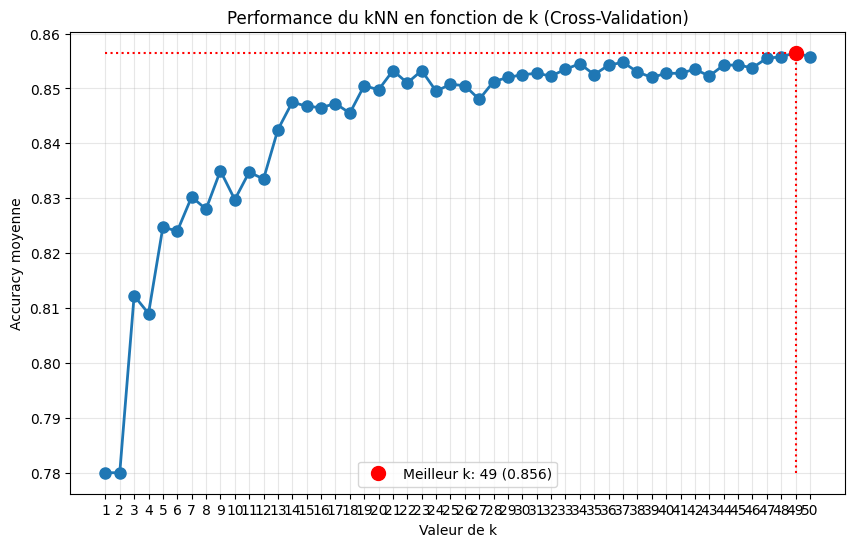

Accuracy finale sur le test set: 0.8600 (86.00%) avec k k={best_k}
Bayes optimal: 86%


In [32]:
main_knn()

### Test

In [6]:
# Test
accuracy = evaluer_modele(X_test, y_test, 5, 'euclidean', X_train, y_train)
print(f"Avec k=5, accuracy = {accuracy:.3f} ({accuracy*100:.1f}%)")

Avec k=5, accuracy = 0.823 (82.3%)


## Data reduction

In [7]:
def distance(v1,v2):
    """
    Renvoie la distance euclidiennes entre les vecteurs v1 et v2
    """
    somme = 0. 
    for x, y in zip(v1, v2):
        somme += (x - y) ** 2
    return math.sqrt(somme)

def un_NN(p, X, y): # TODO à optimiser en se servant des distances déjà calculées pour le k-NN 
    """
    1-NN 

    Args:
        p: Point à tester
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        label: label du point le plus proche 
    """

    # Initialisation 
    # dmin = distance(p, X[0])
    dmin = cdist(p.reshape(1, -1), X[0].reshape(1, -1), metric="euclidean")[0][0]
    label = y[0]

    for i in range(1, X.shape[0]):
        #d = distance(p, X[i])
        d = cdist(p.reshape(1, -1), X[i].reshape(1, -1), metric="euclidean")[0][0]
        if d < dmin: # si on trouve un point plus proche 
            dmin = d
            label = y[i]
    
    return label

def sep_data(X, y):
    """
    Mélange et sépare les données 

    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        l_id: Liste d'indices 
        milieu: indice du milieu
    """
    l_id = [i for i in range(X.shape[0])]
    random.shuffle(l_id)
    milieu = len(l_id) // 2
    return (l_id, milieu)

def reduction1(X, y):
    """
    1ère algorithme de réduction du dataset vu en cours 
    Suppression de la zone de biais 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Split randomly S into two subsets S1 and S2;
    (ordre, milieu) = sep_data(X, y)
    S1_X, S1_y = X[ordre[:milieu]], y[ordre[:milieu]]
    S2_X, S2_y = X[ordre[milieu:]], y[ordre[milieu:]]

    ch = True 
    while (ch): # Tant qu'il y a un changement S1 et S2 ne sont pas stabilisées 
        ch = False

        # Classify S1 with S2 using the 1-NN rule;
        # Remove from S1 the misclassified instances;
        nv_S1_X = []
        nv_S1_y = []
        for xi, yi in zip(S1_X, S1_y):
            l = un_NN(xi, S2_X, S2_y)
            if l == yi: 
                nv_S1_X.append(xi)
                nv_S1_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S1_X = np.array(nv_S1_X)
        S1_y = np.array(nv_S1_y)

        # Classify S2 with the new set S1 using the 1-NN rule;
        # Remove from S2 the misclassified instances;
        nv_S2_X = []
        nv_S2_y = []
        for xi, yi in zip(S2_X, S2_y):
            l = un_NN(xi, S1_X, S1_y)
            if l == yi: 
                nv_S2_X.append(xi)
                nv_S2_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S2_X = np.array(nv_S2_X)
        S2_y = np.array(nv_S2_y)
    
    # Union de S1 et S2 
    X_cleaned = np.concatenate((S1_X, S2_X), axis=0)
    y_cleaned = np.concatenate((S1_y, S2_y))
    
    return (X_cleaned, y_cleaned)

def reduction2(X, y):
    """
    2ème algorithme de réduction du dataset vu en cours 
    Suppression des données non pertinentes 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Initialisation
    STORAGE_X = []
    STORAGE_y = []
    DUSTBIN_X = []
    DUSTBIN_y = []

    # Draw randomly a training example from S and put it in STORAGE;
    idx0 = random.randint(0, X.shape[0] - 1)
    STORAGE_X.append(X[idx0])
    STORAGE_y.append(y[idx0])

    ch = True
    while (ch): # Tant que STORAGE n'est pas stabilisé 
        ch = False
        
        for xi, yi in zip(X, y):

            # Ne pas traiter un point déjà dans STORAGE 
            liste_STORAGE_X = [p.tolist() for p in STORAGE_X]
            if xi.tolist() in liste_STORAGE_X:
                continue

            l = un_NN(xi, np.array(STORAGE_X), np.array(STORAGE_y))

            if l == yi: # if xi is correctly classified with STORAGE using the 1-NN rule
                # bien classé -> poubelle (inutile)
                DUSTBIN_X.append(xi)
                DUSTBIN_y.append(yi)
            else:
                # mal classé -> stockage (utile)
                STORAGE_X.append(xi)
                STORAGE_y.append(yi)
                ch = True

    return (np.array(STORAGE_X), np.array(STORAGE_y))


### PCA

In [11]:
def pca(X, y, titre):
    """
    PCA
    
    Args:
        X: Features du dataset
        y: Labels du dataset 
    
    """

    X_pca = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)

    labels = X_pca[:, -1].astype(int)
    X_features = X_pca[:, :-1]

    # Centrer les données (features)
    X_meaned = X_features - np.mean(X_features, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    # Valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    # Tri décroissant
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_index]

    # Projection sur les 2 premiers vecteurs propres
    eigenvector_subset = sorted_eigenvectors[:, 0:2]
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # Affichage avec couleur par label
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap='viridis', edgecolor='k')

    # Ajouter une légende
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(titre)
    plt.grid(True)
    plt.show()

### Avant réduction 

In [5]:
# Les fonctions de réductions prennent des tableau numpy 
X_np = X.to_numpy()
y_np = y.to_numpy()

### 1ère réduction 

~ 5-8 minutes

Passe de 5000 lignes à environ 4000

In [8]:
(X_cleaned, y_cleaned) = reduction1(X_np, y_np) 
print(X.shape, "-> X_cleaned :", X_cleaned.shape)

(5000, 21) -> X_cleaned : (4012, 21)


### 2ème réduction

~ 2-4 minutes

Passe de ~4000 lignes à ~800-900 lignes 

In [9]:
(X_cleaned2, y_cleaned2) = reduction2(X_cleaned, y_cleaned)
print(X_cleaned.shape, "-> X_cleaned2 :", X_cleaned2.shape)

(4012, 21) -> X_cleaned2 : (874, 21)


## Affichage

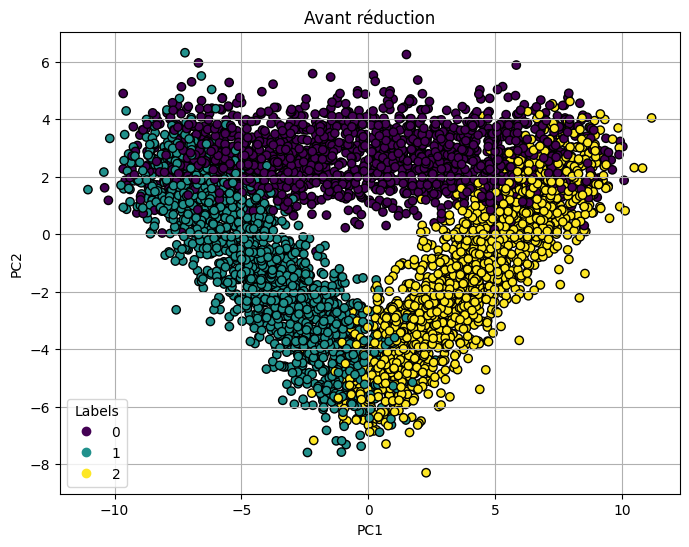

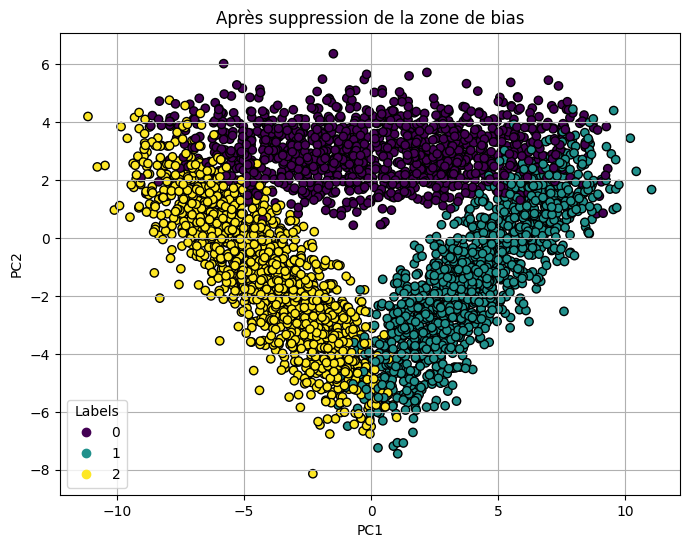

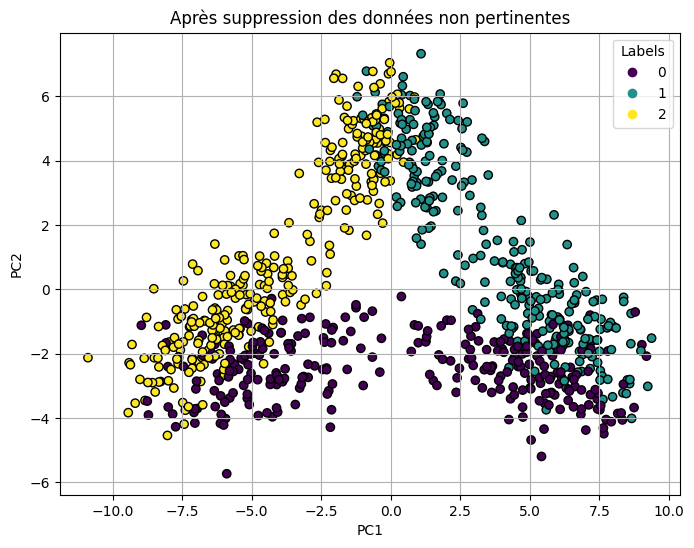

In [12]:
pca(X_np, y_np, "Avant réduction")
pca(X_cleaned, y_cleaned, "Après suppression de la zone de bias")
pca(X_cleaned2, y_cleaned2, "Après suppression des données non pertinentes")

## Lancement du k-NN après réduction des données 

       0     1     2     3     4     5     6     7     8     9   ...    11  \
0   -0.41  0.02 -0.19 -0.86 -1.05  1.11  0.98  3.65  5.70  3.90  ...  2.69   
1    0.05  1.26  1.15  3.12  3.17  3.74  3.00  7.84  3.33  3.93  ...  2.48   
2    0.95 -0.79  1.64  2.23  4.72  2.83  5.75  4.06  3.47  4.63  ...  3.08   
3   -0.58  0.20  0.18  1.68  0.61 -0.16  0.47  0.69 -0.28  2.00  ...  2.70   
4   -0.81 -0.14  2.28  4.20  3.35  4.26  4.69  5.36  4.24  1.60  ...  1.79   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
170  0.67  0.25  0.85  0.56  3.36  2.35  1.97  2.10  1.52  1.49  ...  1.79   
171  0.65  0.25  1.43  2.58  4.31  3.52  3.13  4.98  2.91  3.64  ...  2.68   
172  0.74  0.91  0.90  1.69  3.48  3.75  5.29  4.05  3.31  5.81  ...  5.23   
173  0.51 -0.37  0.52  1.23  3.01  3.07  5.26  5.33  3.18  3.88  ...  2.18   
174 -0.37 -0.19  1.11  0.11  1.54  1.42  1.98  5.00  4.09  5.39  ...  4.11   

       12    13    14    15    16    17    18    19    20  
0  

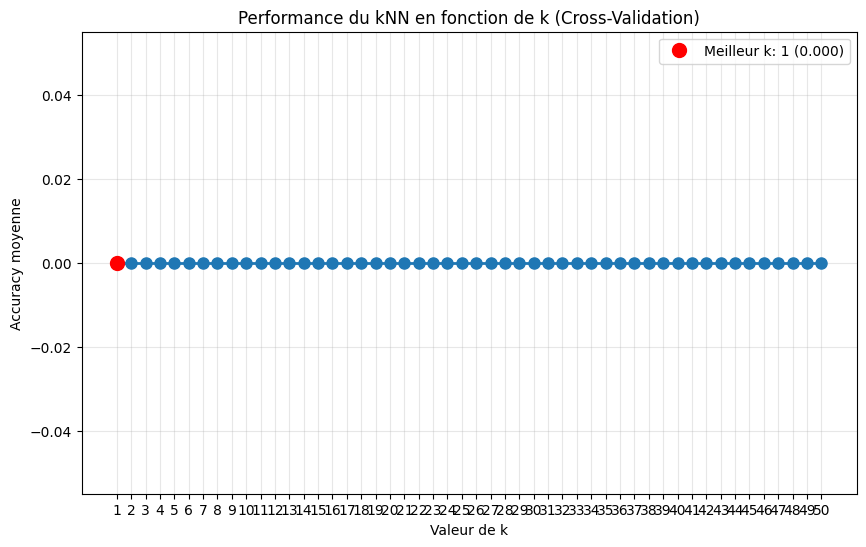

Accuracy finale sur le test set: 0.0000 (0.00%) avec k k={best_k}
Bayes optimal: 86%


In [ ]:
X = pd.DataFrame(X_cleaned2)
y = pd.DataFrame(y_cleaned2)

n = X_cleaned2.shape[0] * 4 // 5

X_train = X.iloc[:n]
y_train = y.iloc[:n]

X_test = X.iloc[n:]
y_test = y.iloc[n:]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

main_knn()